# Hypothesis testing

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkplot.py")

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import random
import thinkstats2
import thinkplot

<IPython.core.display.Javascript object>

## Classical hypothesis testing

Exploring the data from the NSFG, we saw several "apparent effects,"
including differences between first babies and others. So far we have
taken these effects at face value; in this chapter, we put them to the
test.

The fundamental question we want to address is whether the effects we
see in a sample are likely to appear in the larger population. For
example, in the NSFG sample we see a difference in mean pregnancy length
for first babies and others. We would like to know if that effect
reflects a real difference for women in the U.S., or if it might appear
in the sample by chance.

There are several ways we could formulate this question, including
Fisher null hypothesis testing, Neyman-Pearson decision theory, and
Bayesian inference[^1]. What I present here is a subset of all three
that makes up most of what people use in practice, which I will call
**classical hypothesis testing**.

The goal of classical hypothesis testing is to answer the question,
"Given a sample and an apparent effect, what is the probability of
seeing such an effect by chance?" Here's how we answer that question:

-   The first step is to quantify the size of the apparent effect by
    choosing a **test statistic**. In the NSFG example, the apparent
    effect is a difference in pregnancy length between first babies and
    others, so a natural choice for the test statistic is the difference
    in means between the two groups.

-   The second step is to define a **null hypothesis**, which is a model
    of the system based on the assumption that the apparent effect is
    not real. In the NSFG example the null hypothesis is that there is
    no difference between first babies and others; that is, that
    pregnancy lengths for both groups have the same distribution.

-   The third step is to compute a **p-value**, which is the probability
    of seeing the apparent effect if the null hypothesis is true. In the
    NSFG example, we would compute the actual difference in means, then
    compute the probability of seeing a difference as big, or bigger,
    under the null hypothesis.

-   The last step is to interpret the result. If the p-value is low, the
    effect is said to be **statistically significant**, which means that
    it is unlikely to have occurred by chance. In that case we infer
    that the effect is more likely to appear in the larger population.

The logic of this process is similar to a proof by contradiction. To
prove a mathematical statement, A, you assume temporarily that A is
false. If that assumption leads to a contradiction, you conclude that A
must actually be true.

Similarly, to test a hypothesis like, "This effect is real," we assume,
temporarily, that it is not. That's the null hypothesis. Based on that
assumption, we compute the probability of the apparent effect. That's
the p-value. If the p-value is low, we conclude that the null hypothesis
is unlikely to be true.

## HypothesisTest

`thinkstats2` provides `HypothesisTest`, a class that represents the
structure of a classical hypothesis test. Here is the definition:

In [4]:
class HypothesisTest(object):

    def __init__(self, data):
        self.data = data
        self.make_model()
        self.actual = self.test_statistic(data)

    def p_value(self, iters=1000):
        self.test_stats = [self.test_statistic(self.run_model()) for _ in range(iters)]
        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters

    def test_statistic(self, data):
        raise UnimplementedMethodException()

    def make_model(self):
        pass

    def run_model(self):
        raise UnimplementedMethodException()

<IPython.core.display.Javascript object>

`HypothesisTest` is an abstract parent class that provides complete
definitions for some methods and place-keepers for others. Child classes
based on `HypothesisTest` inherit `__init__` and `PValue` and provide
`TestStatistic`, `RunModel`, and optionally `MakeModel`.

`__init__` takes the data in whatever form is appropriate. It calls
`MakeModel`, which builds a representation of the null hypothesis, then
passes the data to `TestStatistic`, which computes the size of the
effect in the sample.

`PValue` computes the probability of the apparent effect under the null
hypothesis. It takes as a parameter `iters`, which is the number of
simulations to run. The first line generates simulated data, computes
test statistics, and stores them in `test_stats`. The result is the
fraction of elements in `test_stats` that exceed or equal the observed
test statistic, `self.actual`.

As a simple example[^2], suppose we toss a coin 250 times and see 140
heads and 110 tails. Based on this result, we might suspect that the
coin is biased; that is, more likely to land heads. To test this
hypothesis, we compute the probability of seeing such a difference if
the coin is actually fair:

In [5]:
class CoinTest(thinkstats2.HypothesisTest):

    def test_statistic(self, data):
        heads, tails = data
        test_stat = abs(heads - tails)
        return test_stat

    def run_model(self):
        heads, tails = self.data
        n = heads + tails
        sample = [random.choice("HT") for _ in range(n)]
        hist = thinkstats2.Hist(sample)
        data = hist["H"], hist["T"]
        return data

<IPython.core.display.Javascript object>

The parameter, `data`, is a pair of integers: the number of heads and
tails. The test statistic is the absolute difference between them, so
`self.actual` is 30.

`RunModel` simulates coin tosses assuming that the coin is actually
fair. It generates a sample of 250 tosses, uses Hist to count the number
of heads and tails, and returns a pair of integers.

Now all we have to do is instantiate `CoinTest` and call `PValue`:

In [6]:
ct = CoinTest((140, 110))
p_value = ct.p_value()
p_value

0.057

<IPython.core.display.Javascript object>

The result is about 0.07, which means that if the coin is fair, we
expect to see a difference as big as 30 about 7% of the time.

How should we interpret this result? By convention, 5% is the threshold
of statistical significance. If the p-value is less than 5%, the effect
is considered significant; otherwise it is not.

But the choice of 5% is arbitrary, and (as we will see later) the
p-value depends on the choice of the test statistics and the model of
the null hypothesis. So p-values should not be considered precise
measurements.

I recommend interpreting p-values according to their order of magnitude:
if the p-value is less than 1%, the effect is unlikely to be due to
chance; if it is greater than 10%, the effect can plausibly be explained
by chance. P-values between 1% and 10% should be considered borderline.
So in this example I conclude that the data do not provide strong
evidence that the coin is biased or not.

## Testing a difference in means

One of the most common effects to test is a difference in mean between
two groups. In the NSFG data, we saw that the mean pregnancy length for
first babies is slightly longer, and the mean birth weight is slightly
smaller. Now we will see if those effects are statistically significant.

For these examples, the null hypothesis is that the distributions for
the two groups are the same. One way to model the null hypothesis is by
**permutation**; that is, we can take values for first babies and others
and shuffle them, treating the two groups as one big group:

In [7]:
class DiffMeansPermute(thinkstats2.HypothesisTest):

    def test_statistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def make_model(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def run_model(self):
        np.random.shuffle(self.pool)
        data = self.pool[: self.n], self.pool[self.n :]
        return data

<IPython.core.display.Javascript object>

`data` is a pair of sequences, one for each group. The test statistic is
the absolute difference in the means.

`MakeModel` records the sizes of the groups, `n` and `m`, and combines
the groups into one NumPy array, `self.pool`.

`RunModel` simulates the null hypothesis by shuffling the pooled values
and splitting them into two groups with sizes `n` and `m`. As always,
the return value from `RunModel` has the same format as the observed
data.

To test the difference in pregnancy length, we run:

In [8]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats/raw/v3/nb/2002FemPreg.dat.gz"
)

<IPython.core.display.Javascript object>

In [9]:
import nsfg

live, firsts, others = nsfg.make_frames()
data = firsts.prglngth.values, others.prglngth.values
ht = DiffMeansPermute(data)
pvalue = ht.p_value()

<IPython.core.display.Javascript object>

`MakeFrames` reads the NSFG data and returns DataFrames representing all
live births, first babies, and others. We extract pregnancy lengths as
NumPy arrays, pass them as data to `DiffMeansPermute`, and compute the
p-value. The result is about 0.17, which means that we expect to see a
difference as big as the observed effect about 17% of the time. So this
effect is not statistically significant.

`HypothesisTest` provides `PlotCdf`, which plots the distribution of the
test statistic and a gray line indicating the observed effect size:

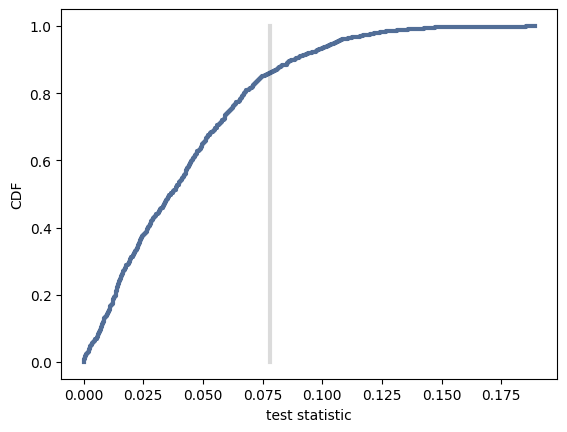

<Figure size 800x600 with 0 Axes>

<IPython.core.display.Javascript object>

In [11]:
ht.plot_cdf()
thinkplot.show(xlabel="test statistic", ylabel="CDF")

Figure [\[hypothesis1\]](#hypothesis1){reference-type="ref"
reference="hypothesis1"} shows the result. The CDF intersects the
observed difference at 0.83, which is the complement of the p-value,
0.17.

If we run the same analysis with birth weight, the computed p-value is
0; after 1000 attempts, the simulation never yields an effect as big as
the observed difference, 0.12 lbs. So we would report $p < 0.001$, and
conclude that the difference in birth weight is statistically
significant.

## Other test statistics

Choosing the best test statistic depends on what question you are trying
to address. For example, if the relevant question is whether pregnancy
lengths are different for first babies, then it makes sense to test the
absolute difference in means, as we did in the previous section.

If we had some reason to think that first babies are likely to be late,
then we would not take the absolute value of the difference; instead we
would use this test statistic:

In [12]:
class DiffMeansOneSided(DiffMeansPermute):

    def test_statistic(self, data):
        group1, group2 = data
        test_stat = group1.mean() - group2.mean()
        return test_stat

<IPython.core.display.Javascript object>

`DiffMeansOneSided` inherits `MakeModel` and `RunModel` from
`DiffMeansPermute`; the only difference is that `TestStatistic` does not
take the absolute value of the difference. This kind of test is called
**one-sided** because it only counts one side of the distribution of
differences. The previous test, using both sides, is **two-sided**.

For this version of the test, the p-value is 0.09. In general the
p-value for a one-sided test is about half the p-value for a two-sided
test, depending on the shape of the distribution.

The one-sided hypothesis, that first babies are born late, is more
specific than the two-sided hypothesis, so the p-value is smaller. But
even for the stronger hypothesis, the difference is not statistically
significant.

We can use the same framework to test for a difference in standard
deviation. In
Section [\[visualization\]](#visualization){reference-type="ref"
reference="visualization"}, we saw some evidence that first babies are
more likely to be early or late, and less likely to be on time. So we
might hypothesize that the standard deviation is higher. Here's how we
can test that:

In [13]:
class DiffStdPermute(DiffMeansPermute):

    def test_statistic(self, data):
        group1, group2 = data
        test_stat = group1.std() - group2.std()
        return test_stat

<IPython.core.display.Javascript object>

This is a one-sided test because the hypothesis is that the standard
deviation for first babies is higher, not just different. The p-value is
0.09, which is not statistically significant.

## Testing a correlation

This framework can also test correlations. For example, in the NSFG data
set, the correlation between birth weight and mother's age is about
0.07. It seems like older mothers have heavier babies. But could this
effect be due to chance?

For the test statistic, I use Pearson's correlation, but Spearman's
would work as well. If we had reason to expect positive correlation, we
would do a one-sided test. But since we have no such reason, I'll do a
two-sided test using the absolute value of correlation.

The null hypothesis is that there is no correlation between mother's age
and birth weight. By shuffling the observed values, we can simulate a
world where the distributions of age and birth weight are the same, but
where the variables are unrelated:

In [14]:
class CorrelationPermute(thinkstats2.HypothesisTest):

    def test_statistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.corr(xs, ys))
        return test_stat

    def run_model(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

<IPython.core.display.Javascript object>

`data` is a pair of sequences. `TestStatistic` computes the absolute
value of Pearson's correlation. `RunModel` shuffles the `xs` and returns
simulated data.

Here's the code that reads the data and runs the test:

In [15]:
live = live.dropna(subset=["agepreg", "totalwgt_lb"])
data = live.agepreg.values, live.totalwgt_lb.values
ht = CorrelationPermute(data)
p_value = ht.p_value()
p_value

0.0

<IPython.core.display.Javascript object>

I use `dropna` with the `subset` argument to drop rows that are missing
either of the variables we need.

The actual correlation is 0.07. The computed p-value is 0; after 1000
iterations the largest simulated correlation is 0.04. So although the
observed correlation is small, it is statistically significant.

This example is a reminder that "statistically significant" does not
always mean that an effect is important, or significant in practice. It
only means that it is unlikely to have occurred by chance.

## Testing proportions

Suppose you run a casino and you suspect that a customer is using a
crooked die; that is, one that has been modified to make one of the
faces more likely than the others. You apprehend the alleged cheater and
confiscate the die, but now you have to prove that it is crooked. You
roll the die 60 times and get the following results:

```
 center
  Value        1   2   3    4   5   6
  ----------- --- --- ---- --- --- ----
  Frequency    8   9   19   5   8   11
```

On average you expect each value to appear 10 times. In this dataset,
the value 3 appears more often than expected, and the value 4 appears
less often. But are these differences statistically significant?

To test this hypothesis, we can compute the expected frequency for each
value, the difference between the expected and observed frequencies, and
the total absolute difference. In this example, we expect each side to
come up 10 times out of 60; the deviations from this expectation are -2,
-1, 9, -5, -2, and 1; so the total absolute difference is 20. How often
would we see such a difference by chance?

Here's a version of `HypothesisTest` that answers that question:

In [16]:
class DiceTest(thinkstats2.HypothesisTest):

    def test_statistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum(abs(observed - expected))
        return test_stat

    def run_model(self):
        n = sum(self.data)
        values = [1, 2, 3, 4, 5, 6]
        rolls = np.random.choice(values, n, replace=True)
        hist = thinkstats2.Hist(rolls)
        freqs = hist.freqs(values)
        return freqs

<IPython.core.display.Javascript object>

The data are represented as a list of frequencies: the observed values
are `[8, 9, 19, 5, 8, 11]`; the expected frequencies are all 10. The
test statistic is the sum of the absolute differences.

The null hypothesis is that the die is fair, so we simulate that by
drawing random samples from `values`. `RunModel` uses `Hist` to compute
and return the list of frequencies.

The p-value for this data is 0.13, which means that if the die is fair
we expect to see the observed total deviation, or more, about 13% of the
time. So the apparent effect is not statistically significant.

## Chi-squared tests

In the previous section we used total deviation as the test statistic.
But for testing proportions it is more common to use the chi-squared
statistic: $$\chi^2 = \sum_i \frac{(O_i - E_i)^2}{E_i}$$ Where $O_i$
are the observed frequencies and $E_i$ are the expected frequencies.
Here's the Python code:

In [17]:
class DiceChiTest(DiceTest):

    def test_statistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum((observed - expected) ** 2 / expected)
        return test_stat

<IPython.core.display.Javascript object>

Squaring the deviations (rather than taking absolute values) gives more
weight to large deviations. Dividing through by `expected` standardizes
the deviations, although in this case it has no effect because the
expected frequencies are all equal.

The p-value using the chi-squared statistic is 0.04, substantially
smaller than what we got using total deviation, 0.13. If we take the 5%
threshold seriously, we would consider this effect statistically
significant. But considering the two tests togther, I would say that the
results are borderline. I would not rule out the possibility that the
die is crooked, but I would not convict the accused cheater.

This example demonstrates an important point: the p-value depends on the
choice of test statistic and the model of the null hypothesis, and
sometimes these choices determine whether an effect is statistically
significant or not.

## First babies again

Earlier in this chapter we looked at pregnancy lengths for first babies
and others, and concluded that the apparent differences in mean and
standard deviation are not statistically significant. But in
Section [\[visualization\]](#visualization){reference-type="ref"
reference="visualization"}, we saw several apparent differences in the
distribution of pregnancy length, especially in the range from 35 to 43
weeks. To see whether those differences are statistically significant,
we can use a test based on a chi-squared statistic.

The code combines elements from previous examples:

In [18]:
class PregLengthTest(thinkstats2.HypothesisTest):

    def make_model(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))
        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.probs(self.values))

    def run_model(self):
        np.random.shuffle(self.pool)
        data = self.pool[: self.n], self.pool[self.n :]
        return data

    def test_statistic(self, data):
        firsts, others = data
        stat = self.chi_squared(firsts) + self.chi_squared(others)
        return stat

    def chi_squared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected) ** 2 / expected)
        return stat

<IPython.core.display.Javascript object>

The data are represented as two lists of pregnancy lengths. The null
hypothesis is that both samples are drawn from the same distribution.
`MakeModel` models that distribution by pooling the two samples using
`hstack`. Then `RunModel` generates simulated data by shuffling the
pooled sample and splitting it into two parts.

`MakeModel` also defines `values`, which is the range of weeks we'll
use, and `expected_probs`, which is the probability of each value in the
pooled distribution.

Here's the code that computes the test statistic:

In [19]:
data = firsts.prglngth.values, others.prglngth.values
ht = PregLengthTest(data)
p_value = ht.p_value()
print("p-value =", p_value)
print("actual =", ht.actual)
print("ts max =", ht.max_test_stat())

p-value = 0.0
actual = 101.50141482893264
ts max = 26.4946075438446


<IPython.core.display.Javascript object>

`TestStatistic` computes the chi-squared statistic for first babies and
others, and adds them.

`ChiSquared` takes a sequence of pregnancy lengths, computes its
histogram, and computes `observed`, which is a list of frequencies
corresponding to `self.values`. To compute the list of expected
frequencies, it multiplies the pre-computed probabilities,
`expected_probs`, by the sample size. It returns the chi-squared
statistic, `stat`.

For the NSFG data the total chi-squared statistic is 102, which doesn't
mean much by itself. But after 1000 iterations, the largest test
statistic generated under the null hypothesis is 32. We conclude that
the observed chi-squared statistic is unlikely under the null
hypothesis, so the apparent effect is statistically significant.

This example demonstrates a limitation of chi-squared tests: they
indicate that there is a difference between the two groups, but they
don't say anything specific about what the difference is.

## Errors

In classical hypothesis testing, an effect is considered statistically
significant if the p-value is below some threshold, commonly 5%. This
procedure raises two questions:

-   If the effect is actually due to chance, what is the probability
    that we will wrongly consider it significant? This probability is
    the **false positive rate**.

-   If the effect is real, what is the chance that the hypothesis test
    will fail? This probability is the **false negative rate**.

The false positive rate is relatively easy to compute: if the threshold
is 5%, the false positive rate is 5%. Here's why:

-   If there is no real effect, the null hypothesis is true, so we can
    compute the distribution of the test statistic by simulating the
    null hypothesis. Call this distribution $\CDF_T$.

-   Each time we run an experiment, we get a test statistic, $t$, which
    is drawn from $CDF_T$. Then we compute a p-value, which is the
    probability that a random value from $CDF_T$ exceeds `t`, so that's
    $1 - CDF_T(t)$.

-   The p-value is less than 5% if $CDF_T(t)$ is greater than 95%; that
    is, if $t$ exceeds the 95th percentile. And how often does a value
    chosen from $CDF_T$ exceed the 95th percentile? 5% of the time.

So if you perform one hypothesis test with a 5% threshold, you expect a
false positive 1 time in 20.

## Power

The false negative rate is harder to compute because it depends on the
actual effect size, and normally we don't know that. One option is to
compute a rate conditioned on a hypothetical effect size.

For example, if we assume that the observed difference between groups is
accurate, we can use the observed samples as a model of the population
and run hypothesis tests with simulated data:

In [20]:
def false_neg_rate(data, num_runs=100):
    group1, group2 = data
    count = 0
    for i in range(num_runs):
        sample1 = thinkstats2.resample(group1)
        sample2 = thinkstats2.resample(group2)
        ht = DiffMeansPermute((sample1, sample2))
        pvalue = ht.p_value(iters=101)
        if pvalue > 0.05:
            count += 1
    return count / num_runs

<IPython.core.display.Javascript object>

`FalseNegRate` takes data in the form of two sequences, one for each
group. Each time through the loop, it simulates an experiment by drawing
a random sample from each group and running a hypothesis test. Then it
checks the result and counts the number of false negatives.

`Resample` takes a sequence and draws a sample with the same length,
with replacement:

In [21]:
def resample(xs):
    return np.random.choice(xs, len(xs), replace=True)

<IPython.core.display.Javascript object>

Here's the code that tests pregnancy lengths:

In [22]:
live, firsts, others = nsfg.make_frames()
data = firsts.prglngth.values, others.prglngth.values
neg_rate = false_neg_rate(data)
neg_rate

0.7

<IPython.core.display.Javascript object>

The result is about 70%, which means that if the actual difference in
mean pregnancy length is 0.078 weeks, we expect an experiment with this
sample size to yield a negative test 70% of the time.

This result is often presented the other way around: if the actual
difference is 0.078 weeks, we should expect a positive test only 30% of
the time. This "correct positive rate" is called the **power** of the
test, or sometimes "sensitivity". It reflects the ability of the test to
detect an effect of a given size.

In this example, the test had only a 30% chance of yielding a positive
result (again, assuming that the difference is 0.078 weeks). As a rule
of thumb, a power of 80% is considered acceptable, so we would say that
this test was "underpowered."

In general a negative hypothesis test does not imply that there is no
difference between the groups; instead it suggests that if there is a
difference, it is too small to detect with this sample size.

## Replication

The hypothesis testing process I demonstrated in this chapter is not,
strictly speaking, good practice.

First, I performed multiple tests. If you run one hypothesis test, the
chance of a false positive is about 1 in 20, which might be acceptable.
But if you run 20 tests, you should expect at least one false positive,
most of the time.

Second, I used the same dataset for exploration and testing. If you
explore a large dataset, find a surprising effect, and then test whether
it is significant, you have a good chance of generating a false
positive.

To compensate for multiple tests, you can adjust the p-value threshold
(see <https://en.wikipedia.org/wiki/Holm-Bonferroni_method>). Or you can
address both problems by partitioning the data, using one set for
exploration and the other for testing.

In some fields these practices are required or at least encouraged. But
it is also common to address these problems implicitly by replicating
published results. Typically the first paper to report a new result is
considered exploratory. Subsequent papers that replicate the result with
new data are considered confirmatory.

As it happens, we have an opportunity to replicate the results in this
chapter. The first edition of this book is based on Cycle 6 of the NSFG,
which was released in 2002. In October 2011, the CDC released additional
data based on interviews conducted from 2006--2010. `nsfg.py` contains
code to read and clean this data. In the new dataset:

-   The difference in mean pregnancy length is 0.16 weeks and
    statistically significant with $p < 0.001$ (compared to 0.078 weeks
    in the original dataset).

-   The difference in birth weight is 0.17 pounds with $p < 0.001$
    (compared to 0.12 lbs in the original dataset).

-   The correlation between birth weight and mother's age is 0.08 with
    $p < 0.001$ (compared to 0.07).

-   The chi-squared test is statistically significant with $p < 0.001$
    (as it was in the original).

In summary, all of the effects that were statistically significant in
the original dataset were replicated in the new dataset, and the
difference in pregnancy length, which was not significant in the
original, is bigger in the new dataset and significant.

## Glossary

-   **hypothesis testing**: The process of determining whether an
    apparent effect is statistically significant.

-   **test statistic**: A statistic used to quantify an effect size.

-   **null hypothesis**: A model of a system based on the assumption
    that an apparent effect is due to chance.

-   **p-value**: The probability that an effect could occur by chance.

-   **statistically significant**: An effect is statistically
    significant if it is unlikely to occur by chance.

-   **permutation test**: A way to compute p-values by generating
    permutations of an observed dataset.

-   **resampling test**: A way to compute p-values by generating
    samples, with replacement, from an observed dataset.

-   **two-sided test**: A test that asks, "What is the chance of an
    effect as big as the observed effect, positive or negative?"

-   **one-sided test**: A test that asks, "What is the chance of an
    effect as big as the observed effect, and with the same sign?"

-   **chi-squared test**: A test that uses the chi-squared statistic as
    the test statistic.

-   **false positive**: The conclusion that an effect is real when it is
    not.

-   **false negative**: The conclusion that an effect is due to chance
    when it is not.

-   **power**: The probability of a positive test if the null hypothesis
    is false.

[^1]: For more about Bayesian inference, see the sequel to this book,
    *Think Bayes*.

[^2]: Adapted from MacKay, *Information Theory, Inference, and Learning
    Algorithms*, 2003.

## Exercises

**Exercise:** As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real.

To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use `thinkstats2.SampleRows` to select a random subset of the rows in a DataFrame.

What happens to the p-values of these tests as sample size decreases? What is the smallest sample size that yields a positive test?

In [23]:
def run_tests(live, iters=1000):
    """Runs the tests from Chapter 9 with a subset of the data.

    live: DataFrame
    iters: how many iterations to run
    """
    n = len(live)
    firsts = live[live.birthord == 1]
    others = live[live.birthord != 1]
    data = firsts.prglngth.values, others.prglngth.values
    ht = DiffMeansPermute(data)
    p1 = ht.p_value(iters=iters)
    data = firsts.totalwgt_lb.dropna().values, others.totalwgt_lb.dropna().values
    ht = DiffMeansPermute(data)
    p2 = ht.p_value(iters=iters)
    live2 = live.dropna(subset=["agepreg", "totalwgt_lb"])
    data = live2.agepreg.values, live2.totalwgt_lb.values
    ht = CorrelationPermute(data)
    p3 = ht.p_value(iters=iters)
    data = firsts.prglngth.values, others.prglngth.values
    ht = PregLengthTest(data)
    p4 = ht.p_value(iters=iters)
    print("%d\t%0.2f\t%0.2f\t%0.2f\t%0.2f" % (n, p1, p2, p3, p4))

<IPython.core.display.Javascript object>

In [24]:
n = len(live)
for _ in range(7):
    sample = thinkstats2.sample_rows(live, n)
    run_tests(sample)
    n //= 2

9148	0.17	0.00	0.00	0.00
4574	0.26	0.00	0.00	0.00
2287	0.87	0.00	0.00	0.00
1143	0.68	0.11	0.04	0.00
571	0.24	0.57	0.50	0.17
285	0.66	0.15	0.47	0.44
142	0.37	0.07	0.01	0.81


<IPython.core.display.Javascript object>

**Exercise:** In Section 9.3, we simulated the null hypothesis by permutation; that is, we treated the observed values as if they represented the entire population, and randomly assigned the members of the population to the two groups.

An alternative is to use the sample to estimate the distribution for the population, then draw a random sample from that distribution. This process is called resampling. There are several ways to implement resampling, but one of the simplest is to draw a sample with replacement from the observed values, as in Section 9.10.

Write a class named `DiffMeansResample` that inherits from `DiffMeansPermute` and overrides `RunModel` to implement resampling, rather than permutation.

Use this model to test the differences in pregnancy length and birth weight. How much does the model affect the results?

In [25]:
class DiffMeansResample(DiffMeansPermute):
    """Tests a difference in means using resampling."""

    def run_model(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        group1 = np.random.choice(self.pool, self.n, replace=True)
        group2 = np.random.choice(self.pool, self.m, replace=True)
        return group1, group2

<IPython.core.display.Javascript object>

In [26]:
def run_resample_test(firsts, others):
    """Tests differences in means by resampling.

    firsts: DataFrame
    others: DataFrame
    """
    data = firsts.prglngth.values, others.prglngth.values
    ht = DiffMeansResample(data)
    p_value = ht.p_value(iters=10000)
    print("\ndiff means resample preglength")
    print("p-value =", p_value)
    print("actual =", ht.actual)
    print("ts max =", ht.max_test_stat())
    data = firsts.totalwgt_lb.dropna().values, others.totalwgt_lb.dropna().values
    ht = DiffMeansPermute(data)
    p_value = ht.p_value(iters=10000)
    print("\ndiff means resample birthweight")
    print("p-value =", p_value)
    print("actual =", ht.actual)
    print("ts max =", ht.max_test_stat())

<IPython.core.display.Javascript object>

In [27]:
run_resample_test(firsts, others)


diff means resample preglength
p-value = 0.1645
actual = 0.07803726677754952
ts max = 0.22159913914705953

diff means resample birthweight
p-value = 0.0001
actual = 0.12476118453549034
ts max = 0.1247893565360636


<IPython.core.display.Javascript object>